In [1]:
import os, sys; os.chdir(".."); sys.path.insert(0, os.path.abspath(os.getcwd()))

In [2]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fetchers.DBAASP import Peptide
import json
from typing import *
from sklearn.feature_selection import r_regression

In [3]:
# Material colors
COLORS = ['#2196F3', '#EF5350', '#81C784', '#FF9800', '#3F51B5', '#FFCA28', '#F48FB1', '#673AB7', '#AED581', '#795548']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLORS)
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.color'] = '#CCCCCC'

In [4]:
ESKAPEE = {
    "Enterococcus faecium",
    "Staphylococcus aureus",
    "Klebsiella pneumoniae",
    "Acinetobacter baumannii",
    "Pseudomonas aeruginosa",
    "Enterobacter",
    "Escherichia coli"
}

def get_eskape_activities(peptide: Peptide, alpha: float = 10.) -> Tuple[dict, dict]:
    targets = [t for t in peptide.targets if t.activityMeasureType == 'MIC']
    species = {}
    for t in targets:
        if 'enterobacter' in t.specie.lower():  # Put all enterobacter under the same name (Enterobacter spp.)
            t.set_name('Enterobacter')
        if t.specie not in species:
            species[t.specie] = []  # Count, activity sum
        mi, ma = t.minActivity, t.maxActivity
        if mi == ma:
            continue    # We want to estimate the range across a specie,but if it was tested on only one strand, there is no information there

        if math.isnan(mi) or math.isnan(ma):
            continue

        if ma == float('inf'):
            ma = mi * alpha
        elif mi == 0:
            mi = ma / 10
        if mi <= 0:
            print("Negative value", mi, "Sequence: ", peptide.sequence, "Specie: ", t.specie)
        species[t.specie].append((mi, ma))

    consensus_activities = {}
    points_mics = {}
    for specie, act in species.items():
        if specie not in ESKAPEE:
            continue
        if len(act) == 0:
            continue    # No range of activity (For different strand)
        mins = [np.log10(a[0]) for a in act]
        maxs = [np.log10(a[1]) for a in act]
        consensus_activities[specie] = np.mean(mins + maxs)
        points_mics[specie] = mins + maxs
    return consensus_activities, points_mics

In [7]:
pred = {specie: [] for specie in ESKAPEE}
targets = {specie: [] for specie in ESKAPEE}
dataset = pd.read_csv("build/whole_dataset.csv")

# Filter no negative
dataset = dataset[dataset["Tag"] != "NegUniprot"]

seqs = set(dataset["Sequence"].values)
with open('build/DBAASP.json', 'r') as f:
    data = json.load(f)
count = 0
for i, sample in enumerate(data):
    peptide = Peptide(sample)
    if peptide.sequence in seqs:
        consensus_activities, points_mics = get_eskape_activities(peptide, alpha=10)
        if len(consensus_activities) != 0:
            count += 1
            deltas = {t: np.array(points_mics[t]) - consensus_activities[t] for t in consensus_activities}
            for t in consensus_activities.keys():
                pred[t].append(np.array(points_mics[t]))
                targets[t].append(np.full_like(points_mics[t], fill_value=consensus_activities[t]))

pred = {key: np.concatenate(values) for key, values in pred.items()}
targets = {key: np.concatenate(values) for key, values in targets.items()}

# Setup
For each peptide entry in the DBAASP database, there are multiple annotations. There can be a MIC for different targets, and there can also be multiple measure of MIC for the same species, but for different strands. Some annotations are a range. This means that the peptide has been tested for a distribution of strands for this specie, and the range correspond to the range of mic for the given specie. Also, some have an undetermined range, meaning that they didn't found any maximum MIC. This should mean that the strand is resistant to the peptide. To model this, we multiply by 10 ($\alpha=10$) the minimum MIC to make the maximum MIC. (We could change this value in the future.) This is also done in the creation of the dataset.

Since our project aims at predicting the consensus MIC for a peptide and a specie, we want to see the correlation of the MIC ranges. To do so, we compute the log mean (consensus value), and assumes the max and min as point values. The consensus is considered as the reference, and we try to see the correlation and difference between the point MICs and the consensus.

In [9]:
ESKAPEE = [
    "Enterococcus faecium",
    "Staphylococcus aureus",
    "Klebsiella pneumoniae",
    "Acinetobacter baumannii",
    "Pseudomonas aeruginosa",
    "Enterobacter",
    "Escherichia coli"
]

Enterococcus faecium
Count:  6077
MAE:  0.42385531435050655
MSE:  0.2129024425414025
PCC:  0.8960145298582409


/Users/alavertu/mac_docs/amp_research/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


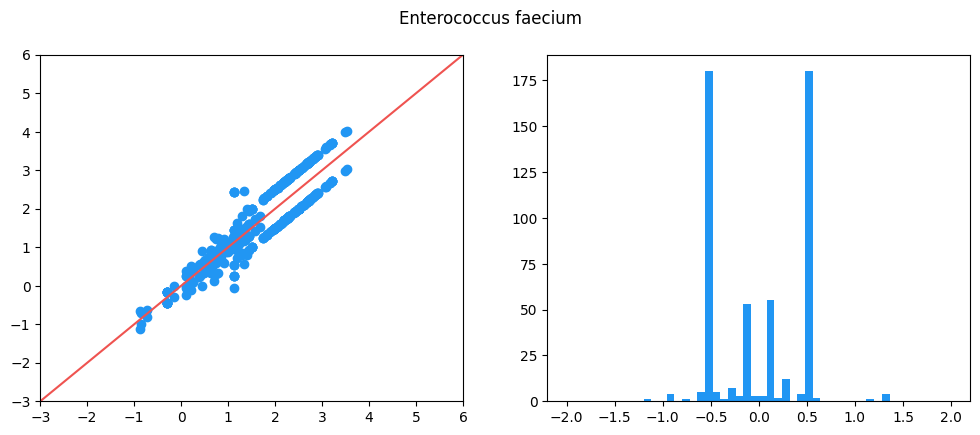

Staphylococcus aureus
Count:  6077
MAE:  0.4446891695140022
MSE:  0.22999184917183296
PCC:  0.8730933351801393


/Users/alavertu/mac_docs/amp_research/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


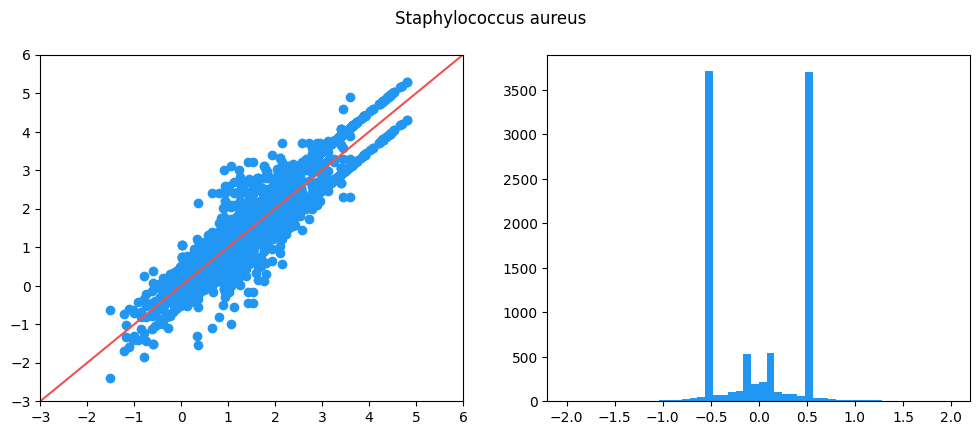

Klebsiella pneumoniae
Count:  6077
MAE:  0.45437451063672013
MSE:  0.2282255285558052
PCC:  0.8708676323311151


/Users/alavertu/mac_docs/amp_research/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


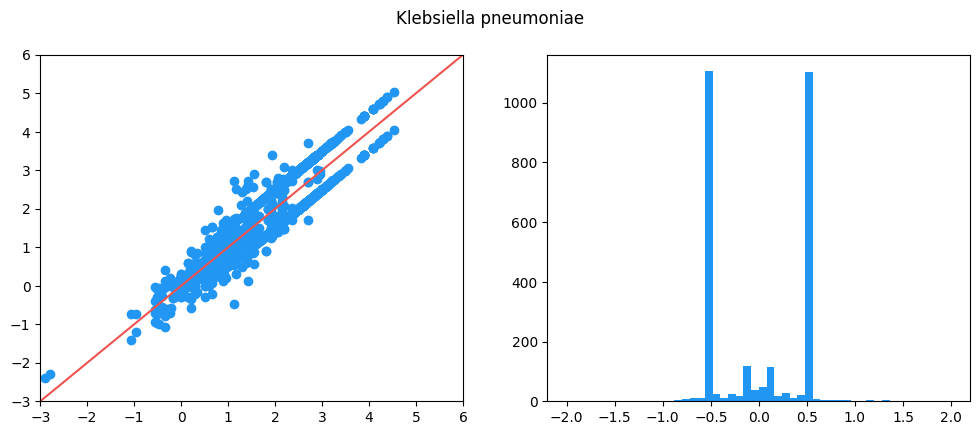

Acinetobacter baumannii
Count:  6077
MAE:  0.4222469678501361
MSE:  0.21560277086759486
PCC:  0.8728341539900443


/Users/alavertu/mac_docs/amp_research/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


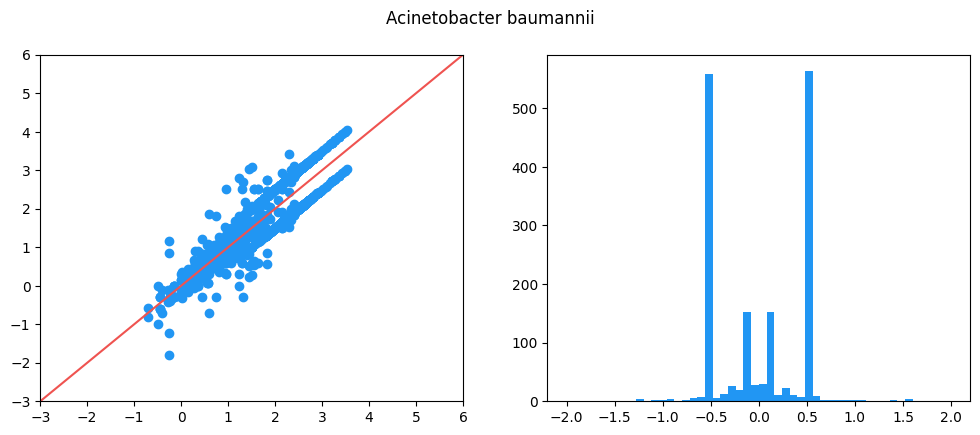

Pseudomonas aeruginosa
Count:  6077
MAE:  0.4590218768765902
MSE:  0.24299661639761636
PCC:  0.856266487623035


/Users/alavertu/mac_docs/amp_research/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


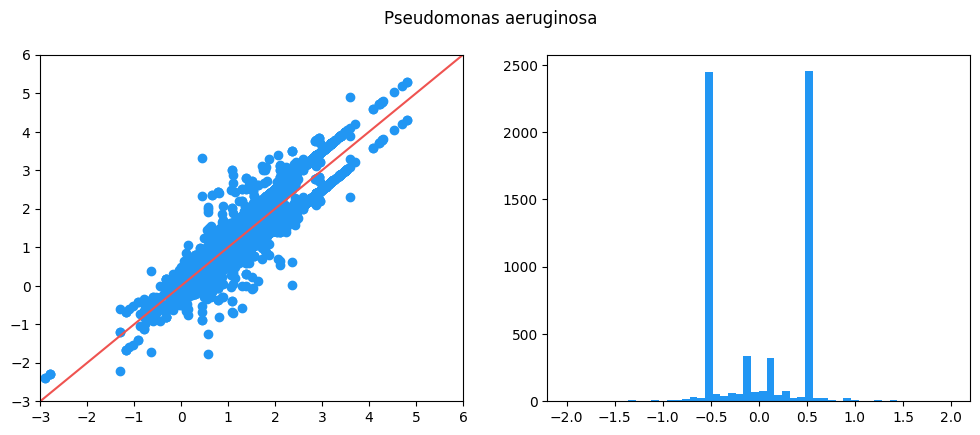

Enterobacter
Count:  6077
MAE:  0.451698956235356
MSE:  0.22386360388371634
PCC:  0.843127249937064


/Users/alavertu/mac_docs/amp_research/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


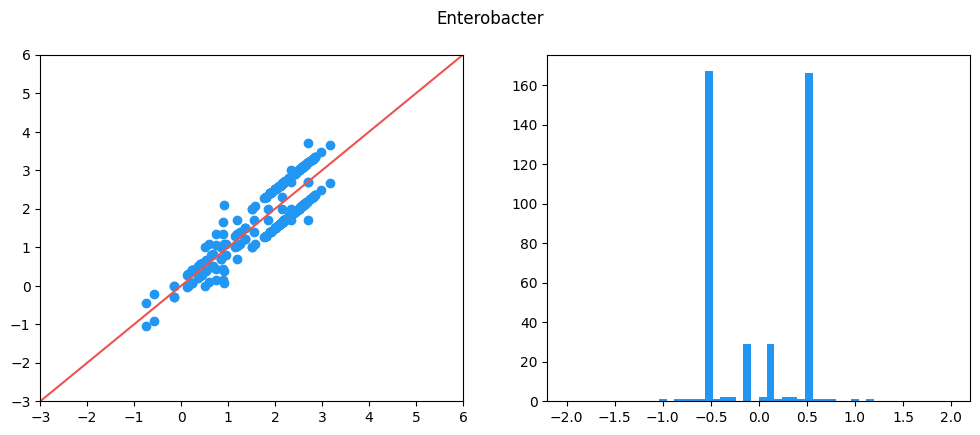

Escherichia coli
Count:  6077
MAE:  0.4226909214524711
MSE:  0.21518656085775667
PCC:  0.9091553900994691


/Users/alavertu/mac_docs/amp_research/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


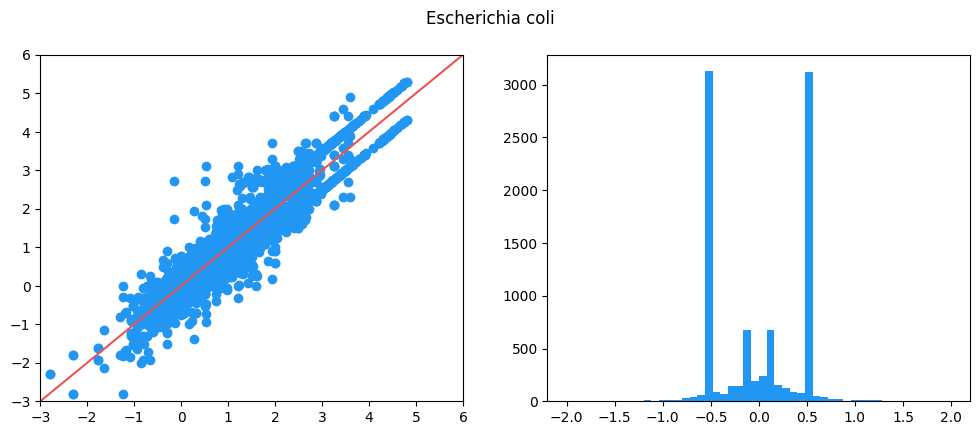

In [14]:
for specie in ESKAPEE:
    print("=" * 100)
    print(specie)
    print("Count: ", count)
    print("MAE: ", np.mean(np.abs(pred[specie] - targets[specie])))
    print("MSE: ", np.mean((pred[specie] - targets[specie]) ** 2))
    print("PCC: ", r_regression(pred[specie][:, None], targets[specie][:, None])[0])
    plt.figure(figsize=(12, 4.5))
    plt.subplot(1, 2, 1)
    plt.scatter(targets[specie], pred[specie])
    plt.plot([-3, 6], [-3, 6], color=COLORS[1])
    plt.xlim(-3, 6)
    plt.ylim(-3, 6)
    plt.subplot(1, 2, 2)
    plt.hist(pred[specie] - targets[specie], bins=50, range=(-2,2))
    plt.suptitle(specie)
    plt.show()

# Analysis

As we can see, there is a strong correlation (PCC: 0.88) and a small error between the extreme values, and the reference one. This suggest that a model could learn this association, and help guide wet lab experiments. It is resonable to consider these metrics as the maximum theoritical performances the model could obtain. To get better results, we would need to predict strand-wise, not specie-wise.

The two peaks that we see at -0.5 and 0.5 are the points MIC for resistant strands. In fact, they are proportional to $\alpha$.

## Limitation
We also found that the assumption that, when a strand is resistant, we multiply the minimum value by 10. However, changing this multiplication factor changes a lot the results. Fo example, the next figure uses a multiplication factor of 100 ($\alpha=100$).

Count:  5548
MAE:  0.8222992163487054
MSE:  0.8095460294782346
PCC:  0.7676253883757945


/Users/alavertu/mac_docs/amp_research/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


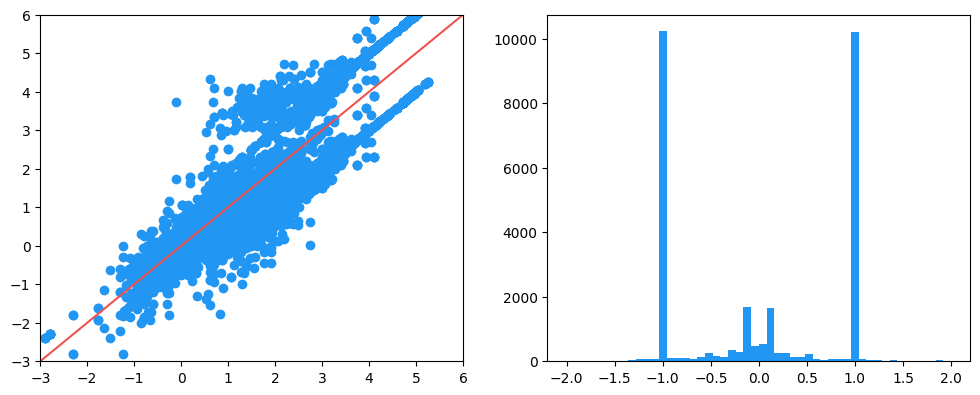

In [15]:
pred = []
targets = []
count = 0
for i, sample in enumerate(data):
    peptide = Peptide(sample)
    if peptide.sequence in seqs:
        consensus_activities, points_mics = get_eskape_activities(peptide, alpha=100)
        if len(consensus_activities) != 0:
            count += 1
            deltas = {t: np.array(points_mics[t]) - consensus_activities[t] for t in consensus_activities}
            for t in consensus_activities.keys():
                pred.append(np.array(points_mics[t]))
                targets.append(np.full_like(points_mics[t], fill_value=consensus_activities[t]))

pred = np.concatenate(pred)
targets = np.concatenate(targets)
print("Count: ", count)
print("MAE: ", np.mean(np.abs(pred - targets)))
print("MSE: ", np.mean((pred - targets) ** 2))
print("PCC: ", r_regression(pred[:, None], targets[:, None])[0])
plt.figure(figsize=(12, 4.5))
plt.subplot(1, 2, 1)
plt.scatter(targets, pred)
plt.plot([-3, 6], [-3, 6], color=COLORS[1])
plt.xlim(-3, 6)
plt.ylim(-3, 6)
plt.subplot(1, 2, 2)
plt.hist(pred - targets, bins=50, range=(-2,2))
plt.show()